# Библиотеки

In [1]:
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn import metrics
from sklearn.pipeline import Pipeline
import sklearn.metrics
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error, mean_squared_log_error,  median_absolute_error, r2_score
from catboost import CatBoostRegressor
import pickle

# Загрузка данных

In [2]:
data = pd.read_csv("Data/data.csv")
data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

# Описание признаков

In [4]:
# Пропуски в данных
data.isna().mean().sort_values(ascending=False).round(4) * 100

private pool    98.89
mls-id          93.39
PrivatePool     89.31
fireplace       72.66
stories         39.96
baths           28.19
beds            24.20
MlsId           17.73
sqft            10.76
status          10.58
propertyType     9.21
target           0.66
city             0.01
street           0.00
zipcode          0.00
schools          0.00
state            0.00
homeFacts        0.00
dtype: float64

In [5]:
# Удалим дублирующиеся записи
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377135 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337218 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342402 non-null  object
 3   street        377133 non-null  object
 4   baths         270827 non-null  object
 5   homeFacts     377135 non-null  object
 6   fireplace     103112 non-null  object
 7   city          377101 non-null  object
 8   schools       377135 non-null  object
 9   sqft          336585 non-null  object
 10  zipcode       377135 non-null  object
 11  beds          285881 non-null  object
 12  state         377135 non-null  object
 13  stories       226462 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40310 non-null   object
 16  MlsId         310266 non-null  object
 17  target        374655 non-null  object
dtypes: object(18)
memory usa

* status        Состояние недвижимости
* private pool  Наличие бассейна
* propertyType  Тип недвижимости
* street        Название улицы
* baths         Количество ванн
* homeFacts     Свойства недвижимости
* fireplace     Наличие камина
* city          Город нахождения недвижимости
* schools       Описание ближайших школ
* sqft          Площадь
* zipcode       Почтовый индекс
* beds          Количество / Площадь спален
* state         Штат нахождения недвижимости
* stories       Количество ближайших магазинов
* mls-id        Номер в службе множественного листинга
* PrivatePool   Наличие бассейна
* MlsId         Номер в службе множественного листинга
* target        Цена объекта (целевой признак)


In [6]:
# Создадим функцию для отчистки целевого признака от лишних символов
def clean_target(x):
    x = int(re.sub('[^0-9]', '', x)) # удаляем все символы кроме цифр.
    return x


# Удалим пропуски в целевом признаке "target"
data.dropna(subset=['target'], inplace=True)
data = data.reset_index(drop=True)

# уберём лишние символы в целевом признаке "target"
data["target"] = data["target"].apply(clean_target)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374655 entries, 0 to 374654
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        335399 non-null  object
 1   private pool  4151 non-null    object
 2   propertyType  340101 non-null  object
 3   street        374653 non-null  object
 4   baths         269308 non-null  object
 5   homeFacts     374655 non-null  object
 6   fireplace     102519 non-null  object
 7   city          374621 non-null  object
 8   schools       374655 non-null  object
 9   sqft          334560 non-null  object
 10  zipcode       374655 non-null  object
 11  beds          283726 non-null  object
 12  state         374655 non-null  object
 13  stories       224902 non-null  object
 14  mls-id        24937 non-null   object
 15  PrivatePool   40120 non-null   object
 16  MlsId         310187 non-null  object
 17  target        374655 non-null  int64 
dtypes: int64(1), object(17)


Удалим признаки имеющие слишком много пропусков, а так же не информативные признаки.


In [7]:
columns_to_delete = ['mls-id', 'MlsId', 'fireplace', 'stories', 'street', 'zipcode']
data.drop(columns_to_delete, axis=1, inplace=True)
data.isna().mean().sort_values(ascending=False).round(4) * 100

private pool    98.89
PrivatePool     89.29
baths           28.12
beds            24.27
sqft            10.70
status          10.48
propertyType     9.22
city             0.01
homeFacts        0.00
schools          0.00
state            0.00
target           0.00
dtype: float64

In [8]:
data.describe(include='all')

,status,private pool,propertyType,baths,homeFacts,city,schools,sqft,beds,state,PrivatePool,target
count,335399,4151,340101,269308,374655,374621,374655,334560,283726,374655,40120,3.746550e+05
unique,156,1,1279,226,318850,2019,295362,25373,1147,39,2,NaN
top,for sale,Yes,single-family home,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,3 Beds,FL,yes,NaN
freq,156054,4151,91370,52072,7142,24406,4177,11853,53072,114652,28686,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.447596e+05
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.841482e+06
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.869900e+05
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.200000e+05
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.820000e+05


In [9]:
df=data.copy()

# Преоброзование данных

### Признак "status"

In [10]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df["status"].value_counts())

for sale                                  156054
Active                                    105206
For sale                                   43464
foreclosure                                 5677
New construction                            5458
Pending                                     4697
Pre-foreclosure                             2000
P                                           1488
Pre-foreclosure / auction                   1281
Under Contract Show                         1183
 / auction                                   799
Under Contract   Showing                     793
Active Under Contract                        718
New                                          690
Under Contract                               690
Contingent                                   581
Price Change                                 563
Auction                                      493
A Active                                     443
for rent                                     398
Foreclosure         


Термины, используемые в сфере продажи-покупки недвижимости:

status - статус, состояние;

estate - объект недвижимости;

'foreclosed' - ('foreclosure')- «лишён права выкупа».

Это процесс, когда недвижимость переходит к кредитору из-за неуплаты ипотеки заёмщиком. Продажа foreclosure-недвижимости отличается от традиционных продаж.

'pre foreclosure' ('pre foreclosure auction') - «до выкупа», «аукцион до выкупа».

'under contract showing', 'under contract show', 'under contract', 'active under contract' - предложение о покупке уже сделано, но не принято продавцом окончательно, и недвижимость продолжают показывать другим потенциальным покупателям.

'under contract backups', 'active backup', 'backup contract' - предложение о покупке уже сделано и принято продавцом, однако он открыт для резервных предложений.

'contingency' - дополнительные обстоятельства (критерии, которым должен соответствовать продавец/покупатель до завершения сделки).

'contingency contract' - контракт на случай возникновения дополнительных обстоятельств.

'active contingency' - сделка уже практически состоялась, однако продавцу/покупателю для её завершения необходимо выполнить какие-то условия.

'insp inspection contingency' - ситуация, когда покупатель может официально проинспектировать объект недвижимости в определённый период времени.

'pending escape clause' - договор, предполагающий свободный выход сторон из него.

'pending backup wanted' - договор уже заключен, однако продавец хочет продолжать показывать недвижимость другим потенциальным покупателям и принимать резервные предложения.

'pending take backups' - условие,предполагающее, что продавец может принимать резерные предложения, если сделка с текущим покупателем не состоится.

'pending continue show financing' - в ожидании оплаты.

'pending continue show' - договор уже заключен, однако продавец хочет продолжать показывать недвижимость другим потенциальным покупателям на случай, если текущая сделка не состоится.

'pending insp finance' - в ожидании проплаты.

'pending inspection' - в ожидании проверки.

'due diligence period' - период, в течение которого покупатель имеет право проинспектировать недвижимость и изучить всю важную для заключения сделки информацию.

'activated' - «активен», открыт для покупки.

'active with contract' - продавец уже принял предложение о покупке, однако сделка ещё не закрыта.

'active option' = = active with contract = = 'active option contract' = = contingency period = = due diligence period - «активный»

'active with offer' - продавец принял предложение о покупке, однако ищет резервные предложения на случай, если сделка с текущим покупателем не состоится.

'active auction', 'auction active', 'auction' - продажа недвижимости с помощью аукциона.

contingency, contingencies - случайность, непредвиденные обстоятельства.

contingent - условный. В сфере недвижимости, когда дом указан как условный, это означает, что предложение было сделано и принято, но до завершения сделки должны быть выполнены некоторые дополнительные критерии.

cooling-off period - период, в течение которого покупатель может расторгнуть договор после завершения сделки.

In [11]:
def remake_status(x):
    old_words = ['auction active', 'pending continue show financing', 'activated']
    old_string = ['active with contract', 'active option contract',
              'contingency period', 'due diligence period']
    new_words = ['active auction', 'pending continue show', 'active']
    if x.startswith('Coming soon'):
        x = 'coming_soon'
    x = x.replace('Showing', 'show')
    x = x.replace('Pf', 'pre foreclosure')
    x = x.replace('Ps', 'pending Sale')
    x = x.replace('Bckp', 'backups')
    x = x.replace('insp', 'inspection')
    x = x.lower()
    x = re.sub('[^a-z:]', ' ', x)
    x = re.sub(r'\b\w{,2}\b', '', x)
    x = re.sub(r'\s+', ' ', x)
    x = x.strip()
    if x == "":
        x = "other"
    if x == "auction":
        x = "active auction"            
    if -1 != x.find('for rent'):
        x = 'for rent'
    for i in range(0, len(new_words)):
        x = x.replace(old_words[i], new_words[i])
    for i in range(0, len(old_string)):
        if -1 != x.find(old_string[i]):
            x = 'active option'
    return x

df['status'] = df['status'].fillna('other')
df['status'] = df['status'].apply(remake_status)
df['status'].value_counts()

for sale                 199520
active                   105651
other                     40824
foreclosure                6020
new construction           5458
                          ...  
pending backup wanted         1
conditional contract          1
pending bring backup          1
temporary active              1
backup                        1
Name: status, Length: 72, dtype: int64

In [12]:
top_status = df['status'].value_counts()[:30].index
df['status'] = df['status'].apply(lambda x: x if x in top_status else 'other')
df['status'].value_counts()

for sale                             199520
active                               105651
other                                 41159
foreclosure                            6020
new construction                       5458
pending                                4826
pre foreclosure                        2004
under contract show                    1987
active auction                         1330
pre foreclosure auction                1281
active under contract                   718
under contract                          702
new                                     690
contingent                              581
price change                            563
for rent                                412
foreclosed                              294
under contract backups                  253
contingent finance and inspection       245
pending continue show                   205
contingent show                         115
back market                             112
option pending                  

### Признак "propertyType"

#### Основные типы домов, и краткая характеристика


Co-Op - квартира в жилищном кооперативе;

Apartment - Квартира является частью набора подобных единиц в одном здании. Важной особенностью является то, что вы должны арендовать место у арендодателя. Часто в квартирах и многоквартирных домах есть такие удобства, как ремонтник, прачечная, тренажерный зал или бассейн.;

Condo - Если вам нравятся удобства, которые приходят с квартирой, но вы хотите владеть ею , вам может подойти квартира. Вместо того, чтобы управляющий зданием или арендодатель контролировал вашу квартиру, вы отвечаете за весь ремонт и содержание.;

Single-Family (Detached, Tiny Home) - это отдельный дом на одну семью.  Отдельный  означает, что здание не имеет общих стен с другими домами.;

townhome, townhouse — таунхаус — это жилой дом, находящийся в индивидуальной собственности, который разделяет по крайней мере одну стену с другой единицей и имеет отдельный вход с улицы.;

Cape Cod - черепичная крыша, облицовка деревянным сайдингом, дверь в центре здания, окна по бокам, один-два этажа;

Colonial home - минимум два этажа, симметрия, лестница в центре здания, строгий внешний вид;

Contemporary - чистые, простые линии, нейтральные цвета, натуральные текстуры;

Cottage - небольшая уютная веранда, небольшие жилые помещения;

Craftsman - элементы ручной работы из дерева, выступающие балки, большие колонны;

Greek Revival - большие белые колонны, украшения в греческом стиле, парадный вход;

Farmhouse - прямоугольная планировка, большое крыльцо, амбарная крыша;

French Country - влияние прованса, облицовка камнем, состаренный вид;

Mediterranean - белая штукатурка, дерево и камень в тёплых тонах, черепичные крыши, элементы испанских и итальянских вилл;

Midcentury Modern - сочетание плавных природных и строгих геометрических линий, гладкость, лаконичность, большие окна;

Ranch - один этаж, низкая крыша, открытые жилые помещения, задний двор;

Split-Level - жилые помещения разделены короткими лестничными пролётами;

Tudor - деревянные балки, каменная кладка, асимметричная крутая двускатная крыша;

Victorian (Queen Anne Houses) - два-три и более этажей, богатый декор, крутая двускатная крыша, небольшие башенки, яркий фасад;

European Houses style — кирпич или камень, высокая крутая крыша, высокие окна, часто со ставнями, традиционные декоративные детали (фронтоны, замковые камни);

log home — деревянный дом.

mortgage - ипотека

#### Обработка признака


In [13]:
# Меняем пропуски на "no data"
df['propertyType'] = df['propertyType'].fillna('no data') 

 # Убираем пустые значения и неизвестные типы
df['propertyType'] = df['propertyType'].apply(lambda x: 'no data' if x =="" or x == "unknown" or x ==" " else x)

# Приводим к нижнему регистру
df['propertyType'] = df['propertyType'].apply(lambda x: x.lower()) 
df['propertyType'].value_counts()

single-family home                                             91370
single family                                                  61886
condo                                                          42368
no data                                                        34708
single family home                                             31725
                                                               ...  
contemporary, farmhouse                                            1
2 stories, traditional, mediterranean, texas hill country          1
1 story, contemporary, traditional, mediterranean                  1
loft, warehouse                                                    1
bilevel, converted dwelling, loft with bedrooms, condo/unit        1
Name: propertyType, Length: 1270, dtype: int64

Удалим строки со значением "land", так как исходя из задания нас интересуют именно дома, а не земельные участки.

In [14]:
df['propertyType'] = df['propertyType'].apply(lambda x: x.replace('lot/land', 'land'))
df['propertyType'] = df['propertyType'].apply(lambda x: 'land' if (-1 != x.find('land')) else x)

trash = df[df['propertyType']=='land'].index

df.drop(trash,  inplace=True)
df = df.reset_index(drop=True)

In [15]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df["propertyType"].value_counts())

single-family home                                                                                                                   91370
single family                                                                                                                        61886
condo                                                                                                                                42368
no data                                                                                                                              34708
single family home                                                                                                                   31725
townhouse                                                                                                                            18344
multi-family                                                                                                                          7895
condo/townhome/row home/co-

Наведём небольшой порядок в категориях признака

In [16]:
old = ['one', 'two', '2-', 'stories', '1 1/2', 'tri-', 'single family',
       'singlefamilyresidence', 'townhome',   'bi', 'bi-', 'multi family',
       'hi-', 'high ', 'condominium',  '4 plex', 'other', 'ca2 n', 'cape cod',
       'mid century', 'mid-century',  'mo2 le', 'mo2le', ' / ','mfd',
       'co-op', 'coop',  'modernist', 'key west', 'farm house',
       'queen anne', ' -level', 'floors', 'mobile home', 'manuf/mobile',
       'less than 4 story', 'historic/older', 'quad']

new = ['1', '2', '2 ', 'story',  '1.5', '3 ', 'single-family',
       'single-family', 'townhouse',  '2 ', '2 ',  'multi-family',
       'high-', 'high-', 'condo',  '4-plex', 'other style', 'cabin', 'cape',
       'midcentury', 'midcentury', 'mobile', 'mobile', '/', 'manufactured',
        'cooperative', 'cooperative',  'modern', 'elevated', 'farmhouse',
        'victorian', ' level',  'story', 'manufactured', 'manufactured',
        '3 story', 'historical', '4']

for i in range(0,len(new)):
    df['propertyType'] = df['propertyType'].apply(lambda x: x.replace(old[i], new[i]))


In [17]:
# Удаление сведений, относящихся к этажности для перезаписи в признак 'propertyType'
def type_del_story(x):
    s = x.split(',')
    for i in range(0, len(s)):
        if s[i].find('story')!=-1:
            if len(s)==1 and i==0:
                s[i] = 'other'
            if len(s)>1:
                s[i] = ','
            if len(s)>1 and i==0:
                s[i]=''
        x = '' .join(s).strip()
    return x.strip(",")
# Выделим этажность домов
df['Property_story'] = df['propertyType'].apply(lambda x: x if -1!= x.find('story') else 'no')

# Выделим индексы строк, имеющие данные об этажности
ind_story = df[df['Property_story']!='no'].index

df.loc[ind_story, 'propertyType'] = df['Property_story'][ind_story].apply(type_del_story)

df.drop('Property_story', axis=1, inplace=True)

df['propertyType'][ind_story].value_counts()

other                                       3641
detached                                    2258
traditional                                  541
contemporary                                 266
ranch                                        143
                                            ... 
texas hill country a-frame                     1
colonial contemporary                          1
split level contemporary traditional           1
contemporary ranch traditional craftsman       1
multi-level patio home townhouse               1
Name: propertyType, Length: 123, dtype: int64

В признаке 'propertyType' оставляем основные типы домов

In [18]:
new = ['mediterranean', 'english', 'georgian', 'florida','spanish',
        'lake house', 'tudor', 'victorian', 'ranch', 'townhouse',
        'single-family','multi-family', 'single detached', 'detached',
        'high-rise', 'colonial', 'traditional',
        'condo', 'contemporary', 'other style', 'bungalow', 'craftsman',
        'cape cod','cooperative', 'a-frame',  'custom', 'loft',
        'multi-level', 'attached', 'manufactured',  'side-by-side',
        'cottage',  'french', 'cluster home', 'garden home',
        'farmhouse', 'elevated',  'historical', 'transitional','penthouse',
        'modern']

for i in range(0, len(new)):
    df['propertyType'] = df['propertyType'].apply(lambda x: new[i] if (-1 != x.find(new[i])) else x)

In [19]:
# Присвоение полям новых значений с изменением
old = ['cape','log']
new = ['cape cod','log home']

for i in range(0,len(new)):
    df['propertyType'] = df['propertyType'].apply(lambda x: new[i] if -1!=x.find(old[i])  else x)
df['propertyType'] = df['propertyType'].apply(lambda x: 'historical' if (x=='historic') or (x=='historic vintage') else x)

df['propertyType'] = df['propertyType'].apply(lambda x: 'other style' if (x=='no data') or (x=='other')  else x)

df['propertyType'].value_counts()

single-family      185160
condo               42772
other style         38988
townhouse           27006
multi-family        12169
                    ...  
gambrel                 1
bermuda                 1
back-to-back            1
resort property         1
prairie                 1
Name: propertyType, Length: 141, dtype: int64

Для уменьшения количества категорий оставим ТОП 30 стилей домов

In [20]:
top_type = df['propertyType'].value_counts()[:30].index
df['propertyType'] = df['propertyType'].apply(lambda x: x if x in top_type else 'other style')

df['propertyType'].value_counts()

single-family         185160
condo                  42772
other style            40939
townhouse              27006
multi-family           12169
traditional             7171
detached                5305
cooperative             3834
manufactured            3500
contemporary            3226
ranch                   3104
high-rise               1969
colonial                1342
mediterranean            875
apartment                797
florida                  749
transitional             569
bungalow                 551
garden home              321
cape cod                 313
craftsman                308
tudor                    156
cluster home             155
custom                   146
multiple occupancy       145
victorian                140
spanish                  129
split-level              119
modern                   119
federal                  115
Name: propertyType, dtype: int64

### Признак "homeFacts"

Признак "homeFacts" содержит несколько отдельных данных, имеющих влияние на оценку недвижимости, дома, квартиры. Поэтому выделим эти данные. Для этого приведем содежимое данного признака к формату .json и формируем новые признаки.

In [21]:
# Заменим пропуски на '0'
df['homeFacts'] = df['homeFacts'].apply(lambda x: x.replace('None', '0'))

In [22]:
# Приводим значения с апострофами в правильный вид
old = ["Attch'd", "Addtn'l", '"closet"', "Hennen\'s", "Penske's", "Req'd"]
new = ['Attch`d', 'Addtn`l', '`closet`', 'Hennen`s', 'Penske`s', 'Req`d']

for i in range(0, len(old)):
    df['homeFacts'] = df['homeFacts'].apply(lambda x: x.replace(old[i], new[i]))

df['homeFacts'] = df['homeFacts'].apply(lambda x: x.replace("'",'"')) # Меняем одиночные кавычки на двойные

In [23]:
# Посмотрим как преобразуется признак в формат json
example = df['homeFacts'][200]
examination = json.loads(example)
examination

{'atAGlanceFacts': [{'factValue': '2004', 'factLabel': 'Year built'},
  {'factValue': '', 'factLabel': 'Remodeled year'},
  {'factValue': 'Forced air', 'factLabel': 'Heating'},
  {'factValue': 'Central', 'factLabel': 'Cooling'},
  {'factValue': '2 spaces', 'factLabel': 'Parking'},
  {'factValue': '8,964 sqft lot', 'factLabel': 'lotsize'},
  {'factValue': '$108', 'factLabel': 'Price/sqft'}]}

In [24]:
# Проверяем правильность парсинга в json формат
for i in range(0,len(df)):
    example = df['homeFacts'][i]
    try:
        examination = json.loads(example)
    except:
        print(i)

In [25]:
def app(x, k):
    js = json.loads(x)
    return js['atAGlanceFacts'][k]['factValue']

# Вытягиваем необходимые данные
df['Year_built'] = df['homeFacts'].apply(lambda x: app(x, 0))
df['Remodeled_year'] = df['homeFacts'].apply(lambda x: app(x, 1))
df['Heating'] = df['homeFacts'].apply(lambda x: app(x, 2))
df['Cooling'] = df['homeFacts'].apply(lambda x: app(x, 3))
df['Parking'] = df['homeFacts'].apply(lambda x: app(x, 4))
df['lotsize'] = df['homeFacts'].apply(lambda x: app(x, 5))
df['Price/sqft'] = df['homeFacts'].apply(lambda x: app(x, 6))

#### Признак 'Year_built'

In [26]:
# Создаем значение 0 в признаке "год постройки" по условию
year = float(datetime.now().year)
df['Year_built'] = df['Year_built'].apply(lambda x: '0' if x == 0 or x == 'No Data' or x == '' or len(x) > 4 else x)
df['Year_built'] = df['Year_built'].astype(int)
df['Year_built'].value_counts()

0       36294
2019    32024
2006     7928
2005     7424
2007     7053
        ...  
1809        1
1823        1
1807        1
1799        1
1804        1
Name: Year_built, Length: 224, dtype: int64

In [27]:
# Определим индексы "выбросов"в меньшую сторону.
ind_built_min= df[(df['Year_built'] > 0) & (df['Year_built'] < 1700)].index
df['Year_built'][ind_built_min]

136430    1208
157180    1057
240359    1060
284623    1019
Name: Year_built, dtype: int32

In [28]:
# Определим индексы "выбросов" в большую сторону.
ind_built_max = df[df['Year_built'] >= year].index
df['Year_built'][ind_built_max]

149374    2025
285207    2025
Name: Year_built, dtype: int32

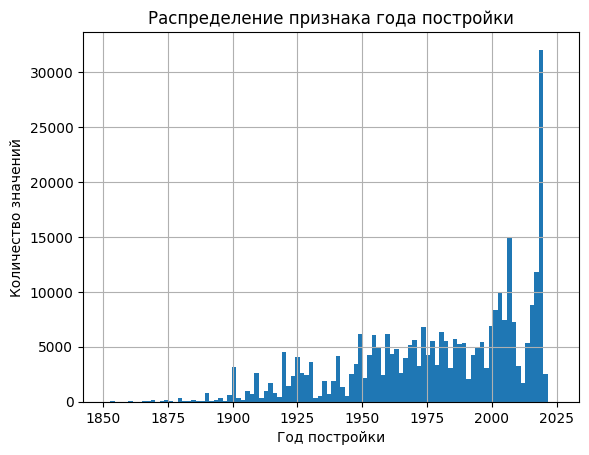

In [29]:
plt.xlabel('Год постройки')
plt.ylabel('Количество значений')
plt.title('Распределение признака года постройки')
df['Year_built'][df['Year_built'] > 1850].hist(bins=100)
plt.show();

In [30]:
df.loc[ind_built_min, 'Year_built'] = 0

df.loc[ind_built_max, 'Year_built'] = year

In [31]:
# Преобразуем признак год постройки в возраст здания

df['Year_built'] =  df['Year_built'].apply(lambda x: float(year-x) if x!=0 else -1.0)
df['Year_built']

0           5.0
1           5.0
2          63.0
3          18.0
4         104.0
          ...  
343199     34.0
343200    100.0
343201     74.0
343202     -1.0
343203      5.0
Name: Year_built, Length: 343204, dtype: float64

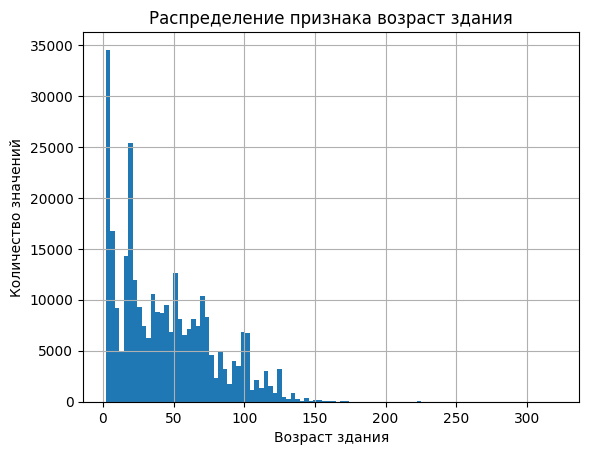

In [32]:
plt.xlabel('Возраст здания')
plt.ylabel('Количество значений')
plt.title('Распределение признака возраст здания')
df['Year_built'][df['Year_built'] > 0].hist(bins=100)
plt.show();

####  Признак 'Remodeled_year'

In [33]:
# Признак "год реконструкции"
df['Remodeled_year'] = df['Remodeled_year'].apply(lambda x: '0' if x == 0 or x == '' else x)
df['Remodeled_year'] = df['Remodeled_year'].astype(int)
df['Remodeled_year'].value_counts()

0       195304
2006      5477
2005      4769
2007      4348
2008      3757
         ...  
1869         1
1853         1
1870         1
1845         1
1862         1
Name: Remodeled_year, Length: 150, dtype: int64

In [34]:
# Также определим индексы "выбросов" в меньшую сторону.
ind_remodeled_min = df[(df['Remodeled_year'] > 0) & (df['Remodeled_year'] < 1700)].index
df['Remodeled_year'][ind_remodeled_min]

Series([], Name: Remodeled_year, dtype: int32)

In [35]:
# Определим индексы "выбросов" в большую сторону.
ind_remodeled_max = df[df['Remodeled_year'] >= year].index
df['Remodeled_year'][ind_remodeled_max]

Series([], Name: Remodeled_year, dtype: int32)

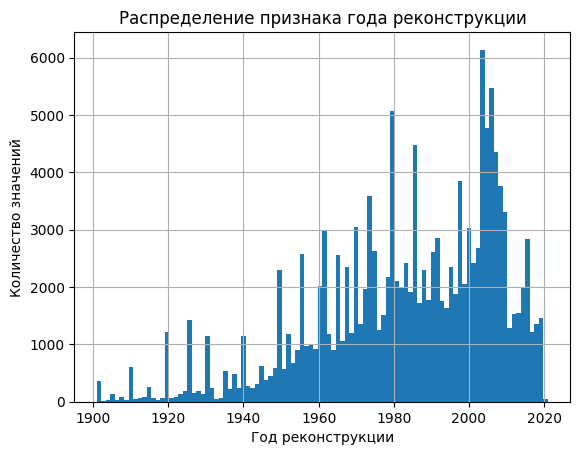

In [36]:
plt.xlabel('Год реконструкции')
plt.ylabel('Количество значений')
plt.title('Распределение признака года реконструкции')
df['Remodeled_year'][df['Remodeled_year'] > 1900].hist(bins=100)
plt.show();

In [37]:
df.loc[ind_remodeled_min, 'Remodeled_year'] = 0
df.loc[ind_remodeled_max, 'Remodeled_year'] = year

In [38]:
# Cоздадим признак возраст с момента реконструкции
df['Remodeled_year'] =  df['Remodeled_year'].apply(lambda x: float(year-x) if x!=0 else -1.0)
df['Remodeled_year'].value_counts()

-1.0      195304
 18.0       5477
 19.0       4769
 17.0       4348
 16.0       3757
           ...  
 155.0         1
 171.0         1
 154.0         1
 179.0         1
 162.0         1
Name: Remodeled_year, Length: 150, dtype: int64

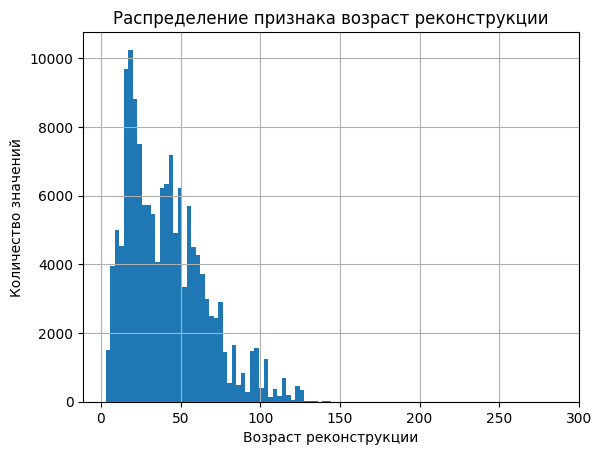

In [39]:
plt.xlabel('Возраст реконструкции') # Чем показатель меньше, тем лучше
plt.ylabel('Количество значений')
plt.title('Распределение признака возраст реконструкции')
df['Remodeled_year'][df['Remodeled_year'] > 0].hist(bins=100)
plt.show();

#### Признак "Parking"

In [40]:
# Сделаем признак бинарным: 0 - нет паркинга, 1 - есть паркинг.
df['Parking'] = df['Parking'].apply(lambda x: 0 if x == 0 or x == '' or x == 'No Data' or x == 'No' else 1)
df['Parking'].value_counts()

1    185255
0    157949
Name: Parking, dtype: int64

#### Признаки 'Heating' и 'Cooling

Два признака, 'Heating' и 'Cooling', существенно влияют на цену недвижимости. Поэтому необходимо привести данные этих показателей в пригодную форму для использования.

In [41]:
# Функция для первоначального парсинга признаков 'Heating' и 'Cooling'
patterns = "[!#$%&()'*+.:;<=>?@[\]^_`{|}~—\"]+"
def parsing (x):
    if (x == 0) or (x == '0') or (x == '') or (x == 'No Data'):
        x = 'No'
    x = x.title()
    x = re.sub(patterns, ' ', x)
    if len(x) > 0 and x[0] == ',':
        x = x[1:].strip()
    return x

df['Heating'] = df['Heating'].apply(parsing)

df['Heating'].value_counts()

Forced Air                                                      132503
No                                                               92528
Other                                                            28059
Heat Pump                                                         8731
Central Air                                                       7814
                                                                 ...  
Zoned Heating, Wall Unit Heating, Forced Air Heating                 1
Baseboard, Spacewallunit                                             1
Hot Air, Stove-Pellet                                                1
Natural Gas, Space Heater                                            1
Baseboard, Hot Water, Programmable Thermostat, Radiant Floor         1
Name: Heating, Length: 1887, dtype: int64

In [42]:
#  Выделение индексов строк
ind_H = df[df['Heating']=='Central Air'].index
df['Cooling'][ind_H].value_counts()

Has Cooling    7800
                 14
Name: Cooling, dtype: int64

In [43]:
# Изменеие 'Has Cooling' признака 'Cooling' на 'Central Air' признака 'Heating'.
df.loc[ind_H,'Cooling'] = df['Heating'][ind_H]

df['Cooling'][ind_H].value_counts()

Central Air    7814
Name: Cooling, dtype: int64

In [44]:
# Выделение индексов строк
ind_C = df[df['Cooling']=='Central Heating'].index
df['Heating'][ind_C].value_counts()

Electric Heat                                           1470
Natural Gas Heat                                        1134
Central Cooling                                           71
Electric Heat, Natural Gas Heat                           67
Ceiling Fan, Central Cooling                              25
Other Heating Fuel  See Remarks                           16
Propane  Owned                                             5
Electric Heat, Propane  Owned                              2
Electric Heat, Solar Heat                                  2
Ceiling Fan, Central Cooling, Electric Cooling             2
Central Cooling, Wall-Window A/C                           2
Electric Cooling                                           2
Wall-Window A/C                                            1
Natural Gas Heat, Solar Heat                               1
Central Cooling, Zoned Cooling                             1
Ceiling Fan, Electric Cooling                              1
Ceiling Fan             

In [45]:
# Изменение  признака 'Heating' и  признака 'Cooling'.'Central Heating'
def change(x):
    if -1!=x.find('Gas'):
        x = 'Central Heating '+'Gas'
    if -1!=x.find('Electric '):
        x = 'Central Heating '+'Electric '
    return x

df.loc[ind_C, 'Heating'] = df['Heating'][ind_C].apply(change)
df['Heating'][ind_C].value_counts()
     

Central Heating Electric                                1479
Central Heating Gas                                     1202
Central Cooling                                           71
Ceiling Fan, Central Cooling                              25
Other Heating Fuel  See Remarks                           16
Propane  Owned                                             5
Central Cooling, Wall-Window A/C                           2
Attic Fan, Ceiling Fan, Central Cooling                    1
Ceiling Fan, Central Cooling, Zoned Cooling                1
Central Building Cooling, Central Individual Cooling       1
Ceiling Fan                                                1
Wall-Window A/C                                            1
Central Cooling, Zoned Cooling                             1
Central Building Cooling                                   1
Name: Heating, dtype: int64

In [46]:
df.loc[ind_C,'Cooling']= 'Central'
df['Cooling'][ind_C].value_counts()

Central    2807
Name: Cooling, dtype: int64

In [47]:
ind_CE =df[df['Cooling']=='Electric Heating'].index
df['Heating'][ind_CE].value_counts()

Refrigeration                                                                                   171
Refrigeration, Ceiling Fan S                                                                    144
Refrigeration, Ceiling Fan S , Programmable Thermostat                                           23
No                                                                                                9
Electric Cooling                                                                                  6
Refrigeration, Programmable Thermostat                                                            5
Central Cooling                                                                                   5
1 Window/Wall Air Conditioning Unit                                                               3
Programmable Thermostat                                                                           3
1 Air Conditioner                                                                                 2


In [48]:
df.loc[ind_CE, 'Cooling'] = df['Heating'][ind_CE]
df.loc[ind_CE, 'Heating'] = 'Electric Heating'

fnd =['Air Conditioning','Air Conditionings','Air Conditioner','Air Conditioners','A/C','Ac']

def dop_Heat(x):
    if (-1!=x.find('Forced Air') or -1!=x.find('Heat Pump')) and -1!=x.find('Gas'):
        x='Forced Gas'
    if (-1!=x.find('Forced Air') or -1!=x.find('Heat Pump')) and -1!=x.find('Electric'):
        x='Forced Electric'
    if -1!=x.find('Heat Pump') or x=='Forcedair':
         x='Forced'
    if -1!=x.find('Forced Air') or x=='Forced Warm Air':
        x='Forced'
    for i in range(0, len(fnd)):
        x = x.replace(fnd[i], '')
    if -1!=x.find('Central Air'):
        x='Central'
    if -1!=x.find('Central') and -1!=x.find('Electric'):
        x='Central Electric'
    if -1!=x.find('Central') and -1!=x.find('Gas'):
        x='Central Gas'
    if x== 'Electric':
        x='Central Electric'
    return x

df['Heating'] = df['Heating'].apply(dop_Heat)

In [49]:
gas = ['Gas', 'Forced Gas', 'Central Gas', 'Electric, Gas']
central = ['Central Electric', 'Central Gas', 'Central Furnace', 'Central Heating']
electric = ['Central Electric', 'Forced Electric', 'Electric, Gas']
name_change = ['Wall', 'Refrigeration', 'Baseboard', 'Hot Water', 'Stove', 'Radiator']
def in_gce(x):
    x = x.strip()
    x = x.replace('Units', 'Unit')
    x = x.replace('Unit S', 'Unit')
    if ((-1!=x.find('Gas') or -1!=x.find('Propane')) and (x not in gas)):
        x='Gas'
    if (-1!=x.find('Central') and (x not in central)):
        x='Central'
    if (-1!=x.find('Electric') and (x not in electric)):
        x='Electric'
    for i in range(0, len(name_change)):
        if -1!=x.find(name_change[i]):
            x = name_change[i]
    if -1!=x.find('Heat') and -1==x.find('Heating'):
        x='Heating'
    if -1!=x.find('Heating') and (x not in ['Central Heating', 'Heating System']):
        x='Heating'
    if -1!=x.find('Window Unit') or x=='Window':
        x = 'Window Unit'
    if  -1!=x.find('Hot Air'):
        x='Forced'
    return x

df['Heating'] = df['Heating'].apply(in_gce)

In [50]:
ind_Heat = df['Heating'].value_counts()[:'Stove'].index
ind_Heat

Index(['Forced', 'No', 'Other', 'Central Electric', 'Central', 'Gas',
       'Baseboard', 'Wall', 'Electric', 'Heating System', 'Central Gas',
       'Forced Gas', 'Radiant', 'Forced Electric', 'Central Furnace',
       'Central Heating', 'Heating', 'Electric, Gas', 'Hot Water',
       'Refrigeration', 'Oil', 'Window Unit', 'Radiator', 'Stove'],
      dtype='object')

In [51]:
# Уменьшаем количество категорий признака 'Heating'
df['Heating'] = df['Heating'].apply(lambda x: x if x in ind_Heat else 'other')

df['Heating'] = df['Heating'].apply(lambda x: 'Central Heating' if x == 'Central Heating' or x == 'Central' or x == 'Heating' else x)
df['Heating'] = df['Heating'].apply(lambda x: 'other' if x == 'Other' or x == 'other' else x)

In [52]:
df['Cooling'] = df['Cooling'].apply(parsing)

fnd =['Air Conditioning','Air Conditionings','Air Conditioner','Air Conditioners','A/C','Ac']
name_change = ['Central Air','Hot Air','Window Unit','Refrigeration','Air Purification System',
               'Common Heating/Cooling', 'Zoned','Baseboard','Wall','Other','No']
def dop_Cool(x):
    x = x.strip()
    x = x.replace('Fan S', 'Fan')
    x = x.replace('Unit S', 'Unit')
    for i in range(0, len(fnd)):
        x = x.replace(fnd[i], 'Air Conditioning')
    if -1!=x.find('Air Conditioning'):
        x='Air Conditioning'
    if -1!=x.find('Central') and -1==x.find('Air'):
        x='Central Air'
    for i in range(0, len(name_change)):
        if -1!=x.find(name_change[i]):
            x = name_change[i]
    if -1!=x.find('Central') and -1!=x.find('Electric'):
        x='Central Electric'
    if -1!=x.find('Central') and -1!=x.find('Gas'):
        x='Central Gas'
    if x== 'Electric':
        x='Central Electric'
    if -1!=x.find('Heat Pump') or -1!=x.find('Forced Air'):
        x='Forced Air'
    if -1!=x.find('Window') and -1==x.find('Unit'):
        x = 'Window Unit'
    if -1!=x.find('Ceiling'):
        x = 'Ceiling Fan'
    if -1!=x.find('Air Purification System'):
        x = 'Air Purification System'
    if -1!=x.find('Evaporative'):
        x = 'Evaporative Cooling'
    return x

df['Cooling'] = df['Cooling'].apply(dop_Cool)

In [53]:
ind_Cool = df['Cooling'].value_counts()['Zoned':].index
ind_Cool

Index(['Zoned', 'Yes', 'Ductless Hp-Mini Split', '1', 'Geothermal',
       '2 Or More Units, Electric', 'Contact Manager', 'Natural Gas Heat',
       'Radiant Heat', 'Attic Fan',
       ...
       'Cooling, Heating', 'Individual Cooling', 'Heat Strip', 'Dual',
       'Dehumidifier', 'Radiant Heat, Radiator Heat, Tankless Water Heater',
       'Hot Water, Radiator Heat, Stove Heat', 'Radiant Floor',
       'Ductless/Mini-Split System',
       '90  High Efficiency, Ductless Hp-Mini Split, Tankless Water Heater'],
      dtype='object', length=144)

In [54]:
df['Cooling'] = df['Cooling'].apply(lambda x: x if x in ind_Cool else 'Other')

### Признак "schools"

Признак "schools" как и признак "homeFacts" содержит отдельные данные, имеющие влияние на оценку недвижимости (дома, квартиры). Поэтому выделим эти данные. Для этого также приведем содежимое данного признака к формату .json и сформируем новые признаки.

In [55]:
df['schools'] = df['schools'].apply(lambda x: x.replace('None', '0')) # Меняем пропуски на 0.

old = ["O\'", " O`,",  "'s", "\'Duke\'", "B\'Nai", "B\'inai",  "L\'Ouver", "L\'ouver",  "L\'Banos", "L\'Dovid",
              "Lil\'", "D\'",  "d\'Evelyn", "Q\'", "Loggers\'", "Teach N\'",  "K\'Tana", "R&D`",  "Citizens\'",  "Kids\'",
              "Girls\' ", "d\'Chassidei", "d\'Gur", "d\'Rav", "Pe\'Er", "Be\'Er", "Kids \'R\' Kids", "\'joe\' ",
              "Meadow\'S", "Sheriff\'S", "Friends\' ", "\'Mother\'", "Int\'L", "\'buddy\'"]

new = ['O`',  " O\', ", '`s', '`Duke`', 'B`Nai', 'B`inai',  'L`Ouver', 'L`Ouver', 'L`Banos', 'L`Dovid',
              'Lil`', 'D`', 'd`Evelyn', 'Q`', 'Loggers`', 'Teach N`', 'K`Tana', "R&D\'",   'Citizens`', 'Kids`',
              'Girls` ',  'd`Chassidei','d`Gur', 'd`Rav', 'Pe`Er', 'Be`Er', 'Kids `R` Kids', '`joe` ',
              'Meadow`S', 'Sheriff`S', 'Friends` ', '`Mother`', 'Int`L', '`buddy`']


for i in range(0, len(old)):
  df['schools'] = df['schools'].apply(lambda x: x.replace(old[i], new[i]))

df['schools'] = df['schools'].apply(lambda x: x.replace("'",'"'))

In [56]:
# Для проверки правильности парсинга признака 'schools' в json формат
for i in range(0,len(df)):
    ss = df['schools'].loc[i][1:len(df['schools'][i])-1]
    try:
        sa = json.loads(ss)
    except:
        print(i)

In [57]:
def app_schools(x,k):
    js = json.loads(x[1:len(x)-1])
    if k==0:
        return js['rating']
    if k==1:
        return js['data']['Distance']
    if k==2:
        return js['data']['Grades']
    if k==3:
        return js['name']

df['schools_rating'] = df['schools'].apply(lambda x: app_schools(x,0))
df['schools_Distance'] = df['schools'].apply(lambda x: app_schools(x,1))
df['schools_Grades'] = df['schools'].apply(lambda x: app_schools(x,2))
# Признак названия школ добавлять не будем за ненадобностью

#### Признак 'school_count

Подсчитаем количество школ

In [58]:
df['school_count'] = df['schools_rating'].apply(lambda x: len(x))
df['school_count'].value_counts()

3     192975
8      34491
2      33346
5      28180
4      20901
6       9107
1       7452
7       5345
0       3070
24      1715
13      1025
10       750
63       747
12       714
11       627
9        534
15       502
14       402
22       398
65       338
49       256
16       117
61       109
21        96
17         5
19         2
Name: school_count, dtype: int64

#### Признак 'schools_rating'

In [59]:
def rait_ch(x):
    c = 0
    s = 0
    for i in range(0, len(x)):
        x[i]=x[i].replace('/10', '')
        if x[i].isdigit():
            s+=int(x[i])
            c+=1
    if c!=0:
        s = round(s/c, 2)
    else:
        s = 0
    return s

df['schools_rating'] = df['schools_rating'].apply(rait_ch)

df['schools_rating'].value_counts()

6.00    20535
4.00    18689
5.00    18035
3.00    16459
6.33    14965
        ...  
5.44        1
3.89        1
1.44        1
1.90        1
3.93        1
Name: schools_rating, Length: 232, dtype: int64

#### Признак 'schools_Distance'

In [60]:
# Вычисляется средняя дистанция до школ
def dist_ch(x):
    c = 0
    s = 0
    for i in range(0, len(x)):
        x[i]=x[i].replace('mi', '')
        if float(x[i]):
            s+=float(x[i])
            c+=1
    if c!=0:
        s = round(s/c, 2)
    else:
        s = 0
    return s

df['schools_Distance'] = df['schools_Distance'].apply(dist_ch)

df['schools_Distance']

0          5.54
1          1.33
2          1.96
3          0.75
4          0.00
          ...  
343199    16.60
343200     4.14
343201     0.60
343202     1.23
343203     1.83
Name: schools_Distance, Length: 343204, dtype: float64

### Признак "PrivatePool" & "private pool"

In [61]:
df['private pool'] = df['private pool'].apply(lambda x: 1 if x=='Yes' else 0)
df['PrivatePool'] = df['PrivatePool'].apply(lambda x: 1 if (x=='Yes' or x=='yes') else 0)

In [62]:
# Объединим два признака:
df['PrivatePool'] = df['private pool'] | df['PrivatePool']
df.drop(['private pool'], axis=1, inplace=True)

df['PrivatePool'].value_counts()

0    299261
1     43943
Name: PrivatePool, dtype: int64

### Признак "state"

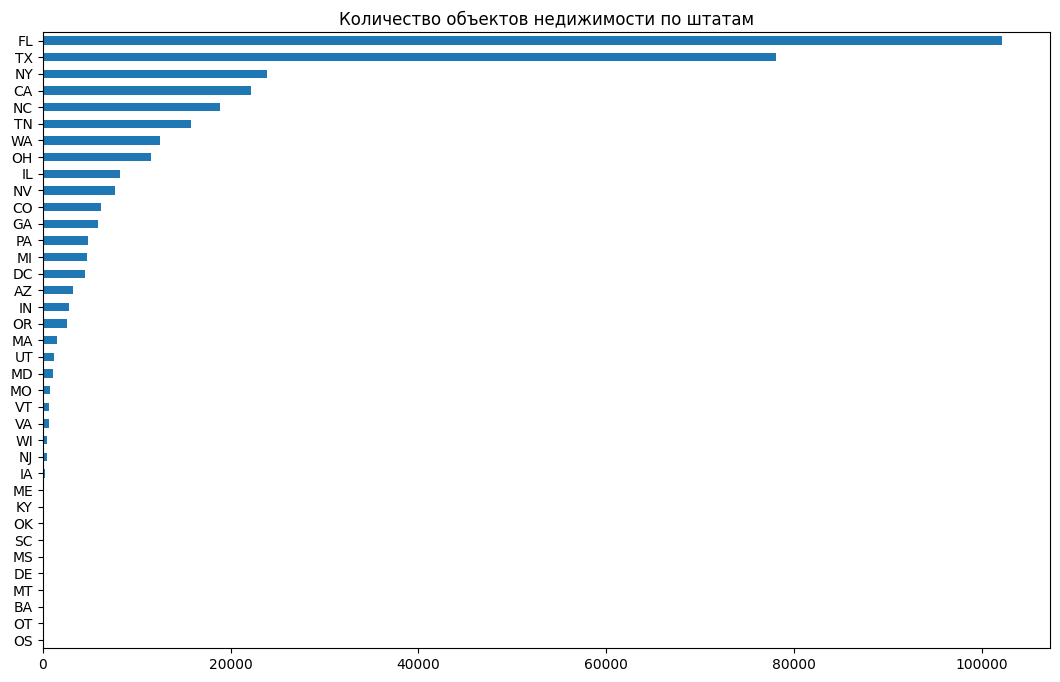

In [63]:
df['state'] = df['state'].apply(lambda x: x.upper())


fig, ax = plt.subplots(figsize=(13, 8))
df['state'].value_counts(ascending = True).plot(kind = 'barh', ax=ax)
ax.set_title('Количество объектов недижимости по штатам');

### Признак "city"

In [64]:
df['city'] = df['city'].fillna('other') # Заменяем пропуски
top_city = df['city'].value_counts().nlargest(200).index

df['city'] = df['city'].apply(lambda x: x if x in top_city else 'other')

### Признак "sqft"

In [65]:
df.sqft = df.sqft.fillna('-1.0')

# Приводим в порядок признак
def make_features_sqft(x):
    x = x.replace('--', '0')
    x = re.sub('[^\-0-9]', '', x)
    if x== '610-840':
        x = '840'
    return x

df.sqft = df.sqft.apply(make_features_sqft)

df['sqft'] = df['sqft'].apply(lambda x: '0' if x=='' else x)
df['sqft'] = df['sqft'].astype(float)

### Признак "baths"

In [66]:
def is_num(x):
    try:
        float(x)
        return True
    except ValueError:
        return False

def make_baths(x):
    x = re.sub('ba','Baths', x)
    x = re.sub('1 1/2', '1.5', x)
    x = x.replace('.0', '')
    x = x.replace('Bathsths','Baths')
    x = x.replace('7,500+','7,500')
    if x == 'Bathrooms: 241':
        x='4 Baths'
    if x == 'Bathrooms: SemiMod':
        x='6 Baths'
    if x == 'Sq. Ft. ':
        x = '0'
    x = x.replace('Bathrooms: ','')
    x = x.replace('Bathrooms: ','')
    x = x.replace('+','+ Baths')
    if x=='1 / 1-0 / 1-0 / 1-0' or x=='2-1 / 2-1 / 1-1 / 1-1':
        x = '2 Baths'
    if x=='1 / 1 / 1 / 1' or x=='1-0 / 1-0 / 1' or x=='3-1 / 2-2':
        x = '3'
    if x=='116 / 116 / 116':
        x='116 Baths'
    if x=='0 / 0' or x== '0.00' or x=='0.0' or x=='00' or x=='0 /':
        x='0'
    if (-1.0!=x.find('--') or -1.0!=x.find('~') or -1.0!=x.find('—')):
        x = '0'
    if is_num(x) and float(x)<120:
        x = x + ' Baths'
    return x

df.baths = df.baths.fillna('0')
df.baths = df.baths.apply(make_baths)

ind_Baths_top = df.baths.value_counts()[:50]

In [67]:
df['beds']= df['beds'].fillna('0')

df['beds_Baths'] = df['beds'].apply(lambda x: x if -1!=x.find('Bath') else ' ')
# Выделим  и сгруппируем для этих индексов данные признака 'baths'
ind_Baths =  df[df['beds_Baths']!=' '].index
# Удалим служебный признак
df.drop('beds_Baths', axis=1, inplace=True)

df.loc[ind_Baths, 'baths'] = df['baths'][ind_Baths].apply(lambda x: '1 Bath' if x== '0 Baths' else x)

ind_Baths_top

2 Baths       100590
0 Baths        79894
3 Baths        64635
4 Baths        25905
1 Baths        16237
2.5 Baths      12589
5 Baths         9197
3.5 Baths       5282
6 Baths         4289
1,500           2207
7 Baths         2070
1.5 Baths       2061
2,000           1791
1,750           1720
3,000           1684
2,250           1440
4.5 Baths       1401
1,000           1279
1,250           1203
8 Baths         1156
2,750            964
2,500            894
3,500            653
9 Baths          544
5.5 Baths        399
10 Baths         327
4,000            289
2.5+ Baths       246
750              237
5,000            229
3.5+ Baths       210
11 Baths         186
4.5+ Baths       156
12 Baths         133
6.5 Baths        128
5.5+ Baths       123
1.75 Baths        87
13 Baths          74
6.5+ Baths        63
1.5+ Baths        55
16 Baths          52
2.1 Baths         49
14 Baths          45
2.75 Baths        34
7.5 Baths         34
18 Baths          32
7.5+ Baths        31
15 Baths     

In [68]:
top_baths = df['baths'].value_counts().nlargest(30)
df['baths'] = df['baths'].apply(lambda x: x if x in top_baths else 'other')

### Признак "beds"

In [69]:
def make_beds(x):
    x = x.replace('bd','Beds')
    x = x.replace('1-2','2')
    x = x.replace('.0', '')
    x = x.replace('--', '0')
    if x=='Baths':
        x='Bath'
    if len(x)>0 and len(x)<=3 and x!='0':
        x = x + ' Beds'
    if( x==' ') or (x=='0 sqft') or (x=='0'):
        x='0 Beds'

    if x==' Beds' or x=='  Beds':
        x='1 Beds'
    if -1!=x.find('3 or More Bedrooms'):
        x = '3+ Beds'
    if -1!=x.find('2 Bedrooms'):
        x = '2 Beds'
    return x

df['beds'] = df['beds'].apply(make_beds)

In [70]:
# Имеются длинные данные, которые не имеют отношения к данному признаку. Их два,поставим 0.
df.beds = df.beds.apply(lambda x: '0 Beds' if len(x)>25 else x)

In [71]:
def is_num(x):
    try:
        float(x)
        return True
    except ValueError:
        return False

def acre_to_sqft(x):
    ed_izm = re.sub('[^A-Z a-z]', '', x).strip()
    value = re.sub('[^0-9\.]', '', x).strip()
    if ed_izm=='acres' or ed_izm=='acre':
        if is_num(value):
            value = round(float(value)*acre_sqft, 1)
            return str(value)+' '+ 'sqft'
        else:
            return value
    if ed_izm=='sqft'  or ed_izm=='':
        if is_num(value):
            value = round(float(value), 1)
            return str(value)+' '+ 'sqft'
        else:
            return value
    if ed_izm =='Beds' or ed_izm=='Bath':
        return x

acre_sqft = 43560

df['beds'] = df['beds'].apply(acre_to_sqft)

Признак 'beds' - категориальный, но можно сделать числовым, разделив признак на два признака: 'count_beds' и 'sqft_beds'

In [72]:
df['sqft_beds'] = df['beds'].apply(lambda x: x if -1!=x.find('sqft') else '0')

df['sqft_beds'].value_counts()

0                340324
5000.0 sqft          90
43560.0 sqft         46
14810.4 sqft         39
12196.8 sqft         37
                  ...  
222591.6 sqft         1
3225.0 sqft           1
1210.0 sqft           1
252212.4 sqft         1
8479.0 sqft           1
Name: sqft_beds, Length: 992, dtype: int64

In [73]:
df['sqft_beds'] = df['beds'].apply(lambda x: float(re.sub('[^0-9\.]', '', x).strip()) if -1!=x.find('sqft') else 0)
df['count_beds'] = df['beds'].apply(lambda x: x if (-1==x.find('sqft'))  else '0')

df['beds'] = df['beds'].apply(lambda x: '999 Beds' if -1!=x.find('Bath') else x)
df['count_beds'] = df['beds'].apply(lambda x: float(re.sub('[^0-9\.]', '', x).strip()) if -1!=x.find('Beds') else 0)

df['count_beds'].value_counts()

3.0      104000
4.0       68122
0.0       67157
2.0       49124
5.0       21482
999.0     15992
6.0        6465
1.0        6428
7.0        1801
8.0        1190
9.0         476
10.0        270
12.0        185
11.0        132
16.0         68
13.0         46
14.0         42
15.0         32
18.0         31
24.0         30
20.0         19
17.0         12
32.0          9
28.0          9
22.0          8
26.0          8
19.0          6
21.0          5
23.0          5
34.0          5
27.0          5
30.0          4
40.0          4
44.0          3
36.0          3
25.0          3
47.0          2
42.0          2
33.0          2
48.0          2
78.0          2
29.0          2
35.0          1
76.0          1
46.0          1
52.0          1
75.0          1
39.0          1
144.0         1
53.0          1
99.0          1
31.0          1
88.0          1
Name: count_beds, dtype: int64

### Удаление признаков: вспомогательные, рабочие и расщипленные на отдельные признаки

In [74]:
feature_drop = ['schools',  'homeFacts', 'beds', 'Price/sqft', 'lotsize', 'schools_Grades']
df.drop(feature_drop, axis=1, inplace=True)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343204 entries, 0 to 343203
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   status            343204 non-null  object 
 1   propertyType      343204 non-null  object 
 2   baths             343204 non-null  object 
 3   city              343204 non-null  object 
 4   sqft              343204 non-null  float64
 5   state             343204 non-null  object 
 6   PrivatePool       343204 non-null  int64  
 7   target            343204 non-null  int64  
 8   Year_built        343204 non-null  float64
 9   Remodeled_year    343204 non-null  float64
 10  Heating           343204 non-null  object 
 11  Cooling           343204 non-null  object 
 12  Parking           343204 non-null  int64  
 13  schools_rating    343204 non-null  float64
 14  schools_Distance  343204 non-null  float64
 15  school_count      343204 non-null  int64  
 16  sqft_beds         34

# Feature engineering

### Выделяем имена числовых признаков в виде списка для удобства дальнейшей работы

In [76]:

types = df.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['sqft',
 'PrivatePool',
 'target',
 'Year_built',
 'Remodeled_year',
 'Parking',
 'schools_rating',
 'schools_Distance',
 'school_count',
 'sqft_beds',
 'count_beds']

### Корреляция

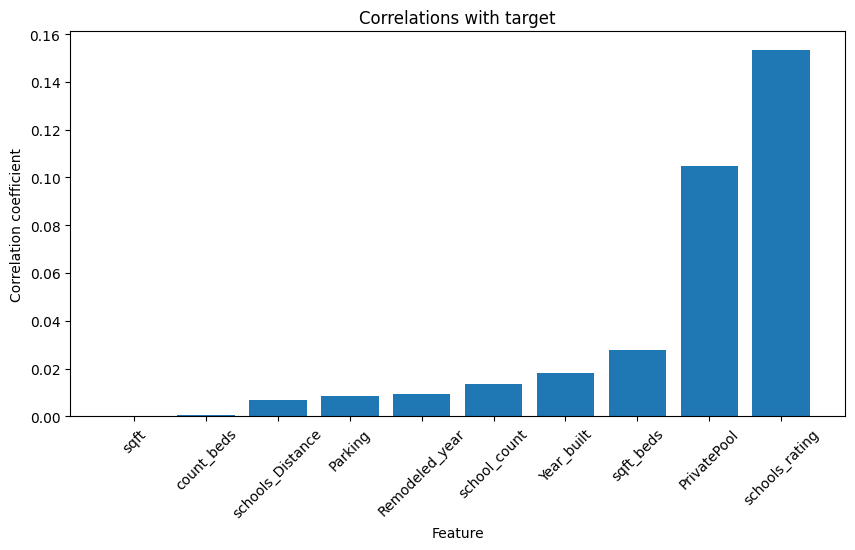

In [77]:
# Вычисляем модуль корреляции
corr_with_target = df.corr()['target'].abs().sort_values()
# Удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('target')
# Строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(10, 5)) #фигура+координатная плоскость
ax.bar(corr_with_target.index, corr_with_target.values) #столбчатая диаграмма
ax.set_title('Correlations with target') #название графика
ax.set_xlabel('Feature') #название оси x
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Сorrelation coefficient'); #название оси y

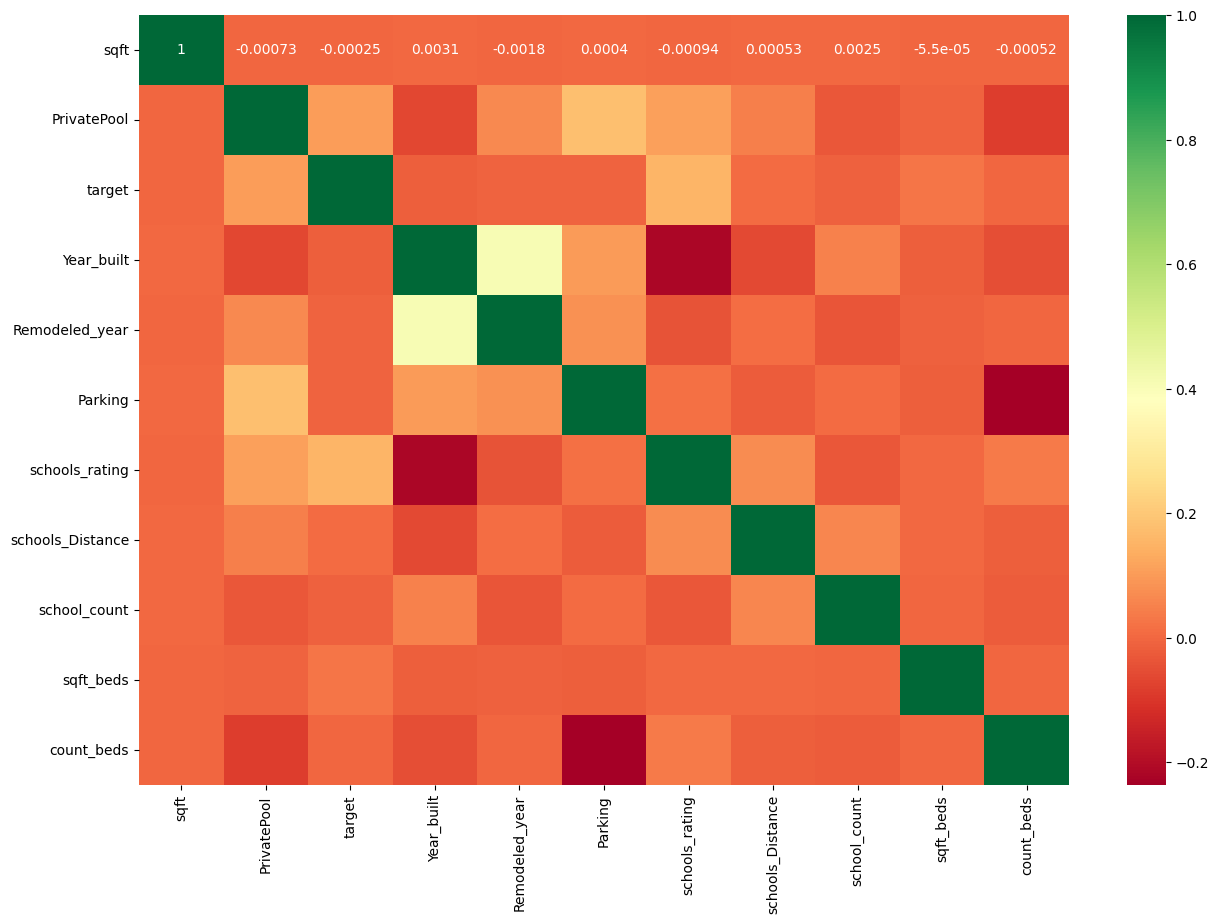

In [78]:
plt.rcParams['figure.figsize']=(15, 10)
sns.heatmap(df.corr(), annot=True, cmap="RdYlGn");

Сильной корреляции не наблюдается.

### Построим несколько графиков.

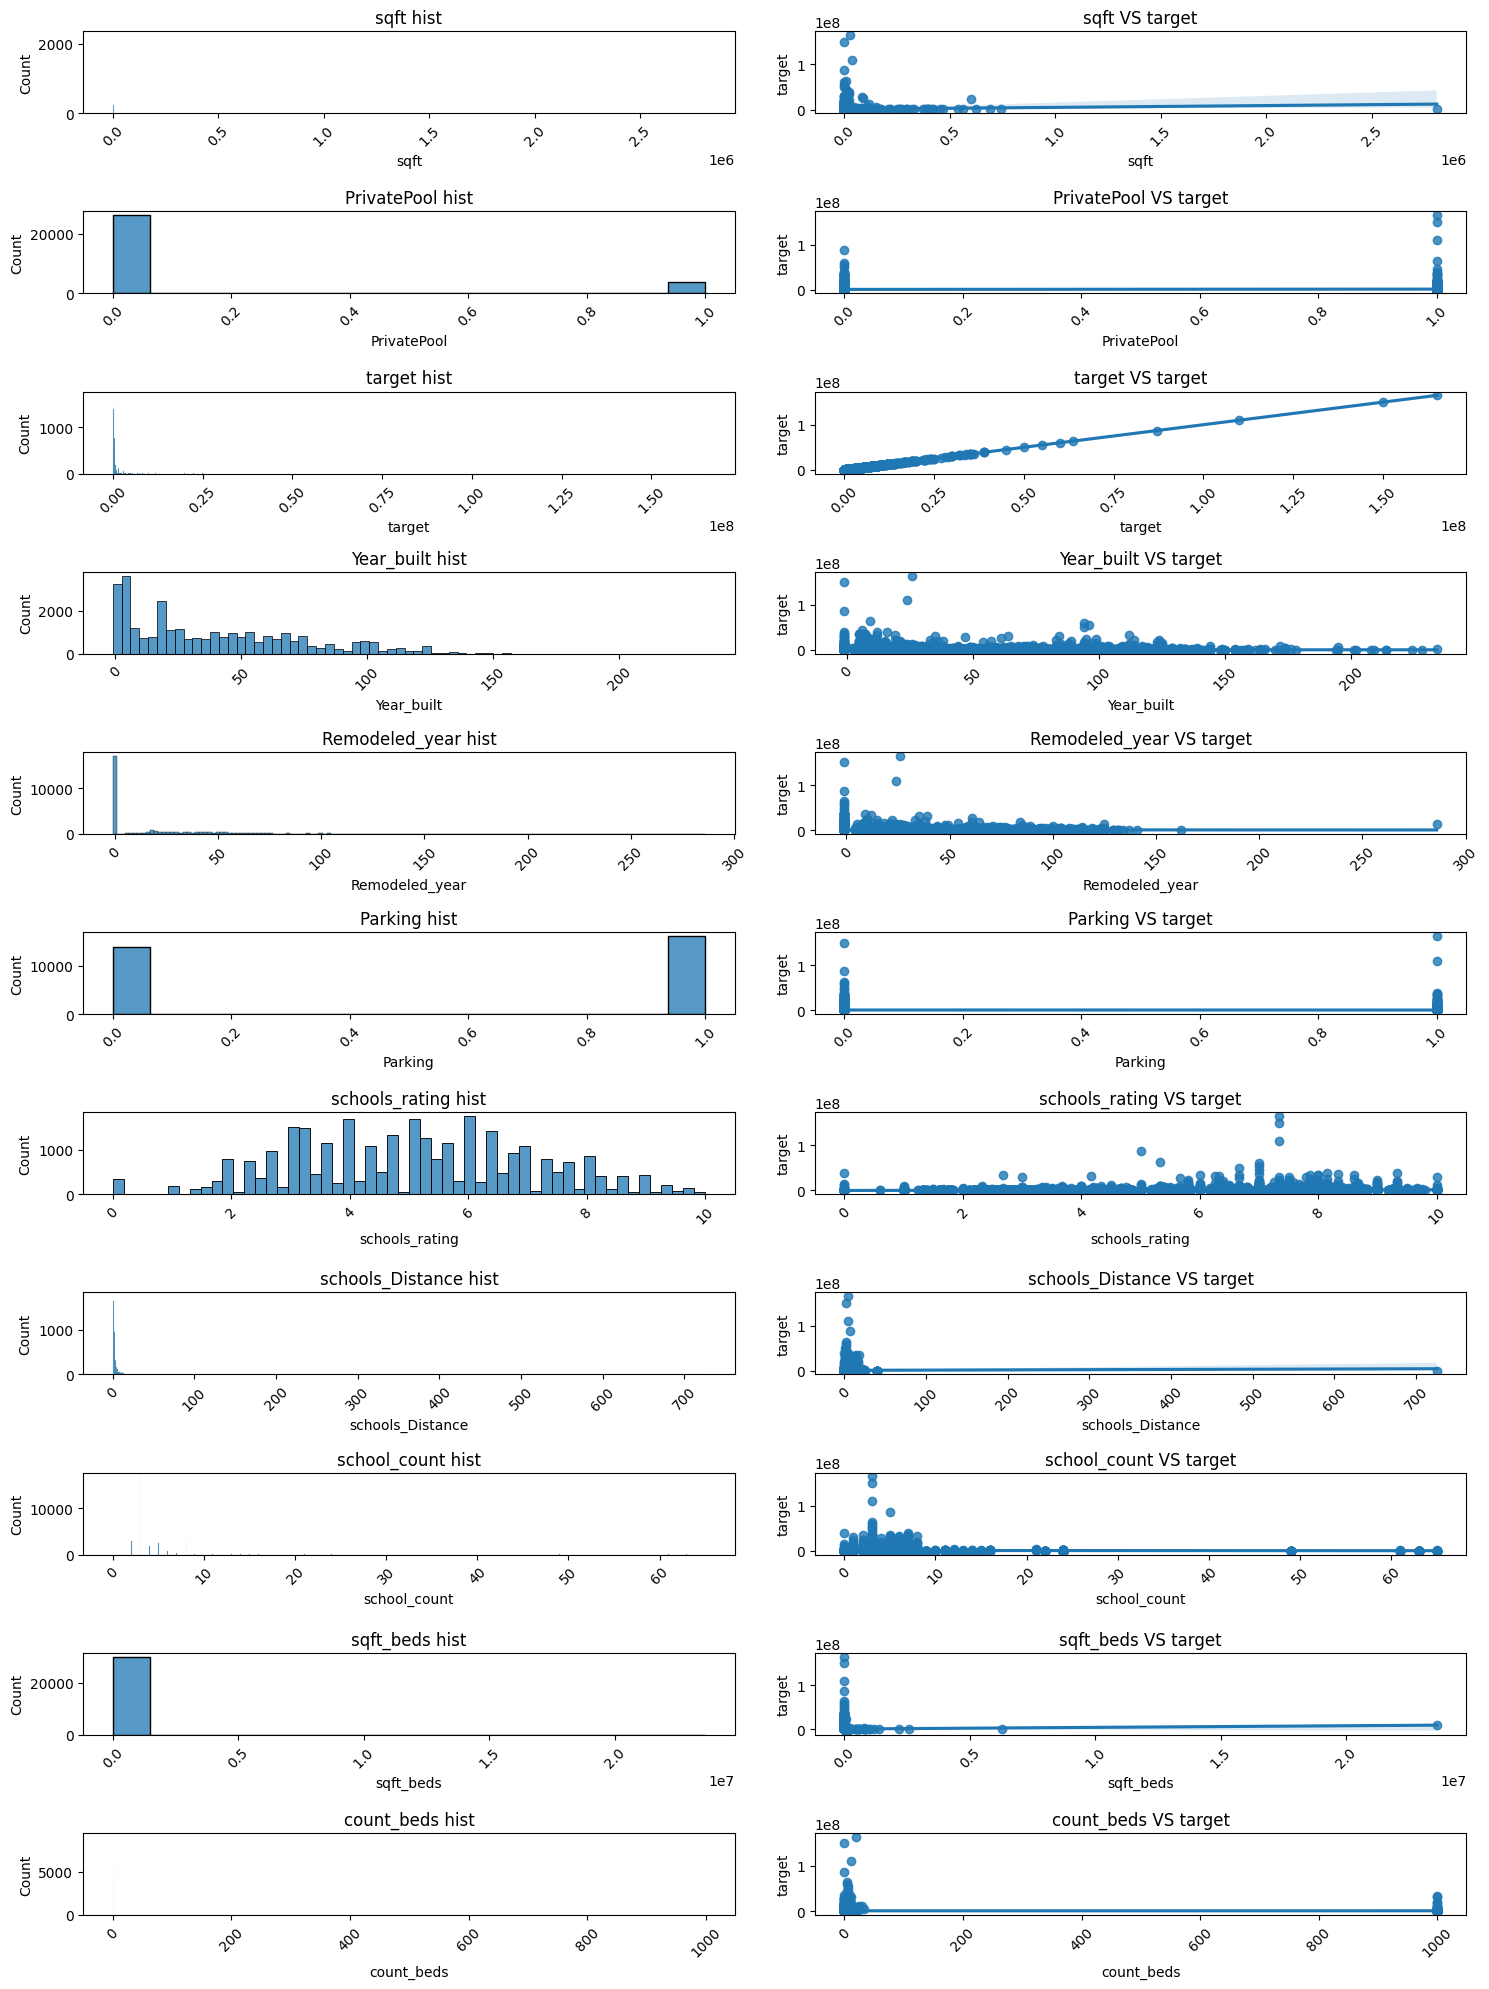

In [79]:
df_1 = df.sample(n=30000)

n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака
    histplot = sns.histplot(data=df_1, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)

    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=df_1, x=feature, y='target', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS target'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

На графиках выше, мы видим распеделение числовых признаков, а также диаграмму рассеяния по каждому признаку + целевой, а также поверх диаграммы строится линейная зависимость по каждой паре признаков.

### Производим кодирование категориальных признаков

In [80]:
df = pd.get_dummies(df)
df.head(3)

,sqft,PrivatePool,target,Year_built,Remodeled_year,Parking,schools_rating,schools_Distance,school_count,sqft_beds,...,Cooling_Space Heater,"Cooling_Space Heater, Stove Heat",Cooling_Stove - Wood,Cooling_Stove Heat,Cooling_Tankless Water Heater,Cooling_Whole House Fan,Cooling_Wood,Cooling_Wood Stove,Cooling_Yes,Cooling_Zoned
0,2900.0,0,418000,5.0,-1.0,0,5.20,5.54,8,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1947.0,0,310000,5.0,-1.0,0,2.67,1.33,3,0.0,...,0,0,0,0,0,0,0,0,0,0
2,3000.0,1,2895000,63.0,57.0,1,6.67,1.96,3,0.0,...,0,0,0,0,0,0,0,0,0,0


### Функция для вывода метрик модели

In [81]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f} $'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('-' * 20)
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f} $'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Test MAPE: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

### Первая модель

In [82]:
# X - матрица наблюдений, y - столбец правильных ответов
X = df.drop('target', axis=1)
y = df['target']

In [83]:
# Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=40 #число отвечающее за генерацию случайных чисел
)
# Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (274563, 506)
Test shape: (68641, 506)


In [84]:
# Строим baseline без преобразований
lr = LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [85]:
#Выводим результирующие метрики
print('LinearRegression без преобразований')
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

LinearRegression без преобразований
Train R^2: 0.261
Train MAE: 445666.188 $
Train MAPE: 390.757 %
--------------------
Test R^2: 0.274
Test MAE: 447195.157 $
Test MAPE: 1629.814 %


### Нормализация

In [86]:
#Создаем объект для min-max нормализации
scaler = MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Инициализируем объект класса линейная регрессия
sgd_lr = SGDRegressor(random_state=42)
#Обучаем модель - ищем параметры
sgd_lr.fit(X_train_scaled, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = sgd_lr.predict(X_train_scaled)
y_test_pred = sgd_lr.predict(X_test_scaled)

In [87]:
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.259
Train MAE: 447413.931 $
Train MAPE: 530.703 %
--------------------
Test R^2: 0.274
Test MAE: 448800.075 $
Test MAPE: 1617.681 %


### Логарифмирование

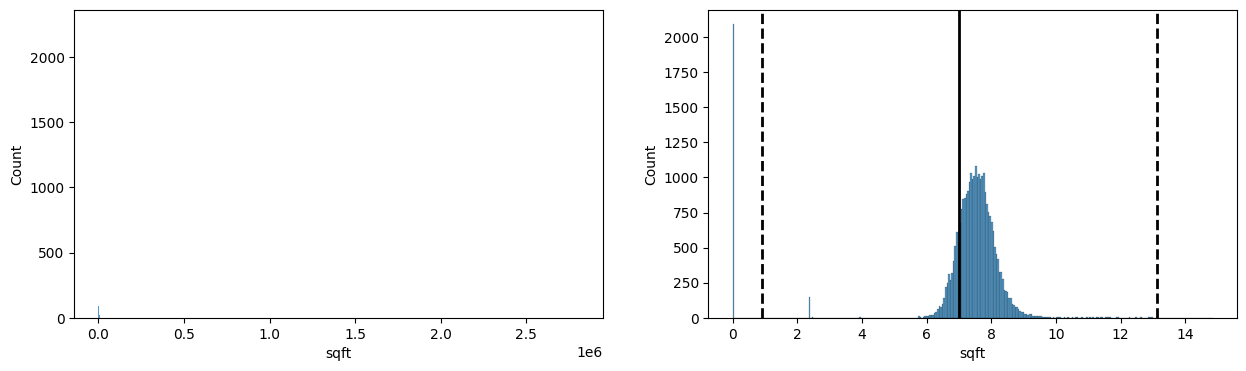

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #фигура + координатная плоскость
#Строим гистограмму
sns.histplot(data=df_1, x='sqft', ax=axes[0]);

#Логарифмируем
log_sqft = np.log(df_1['sqft'] + 11)
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_sqft, ax=axes[1]);

#Добавляем вертикальные линии для среднего и стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_sqft.mean(), color='k', lw=2)
axes[1].axvline(log_sqft.mean()+ 3 *log_sqft.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_sqft.mean()- 3 *log_sqft.std(),
                color='k', ls='--', lw=2);

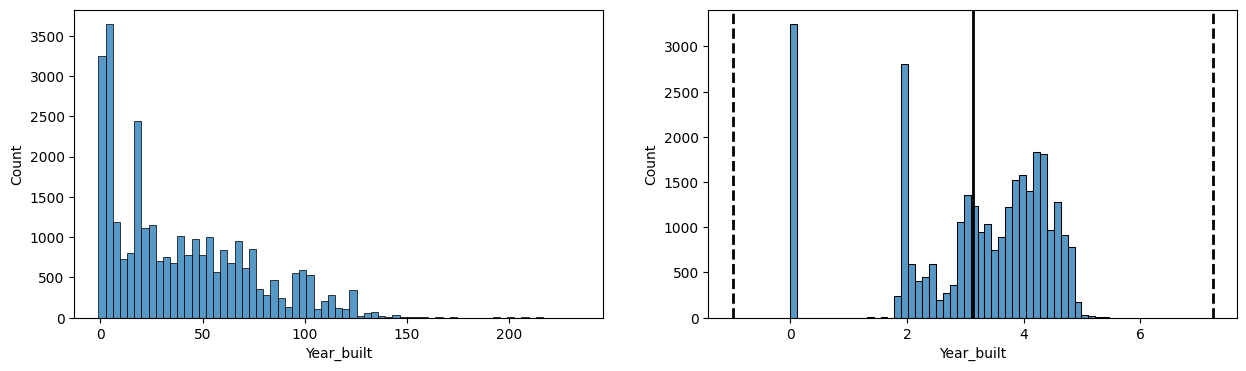

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #фигура + координатная плоскость
#Строим гистограмму
sns.histplot(data=df_1, x='Year_built', ax=axes[0]);

#Логарифмируем
log_Year_built = np.log(df_1['Year_built'] +2)
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_Year_built, ax=axes[1]);

#Добавляем вертикальные линии для среднего и стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_Year_built.mean(), color='k', lw=2)
axes[1].axvline(log_Year_built.mean()+ 3 *log_Year_built.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_Year_built.mean()- 3 *log_Year_built.std(),
                color='k', ls='--', lw=2);

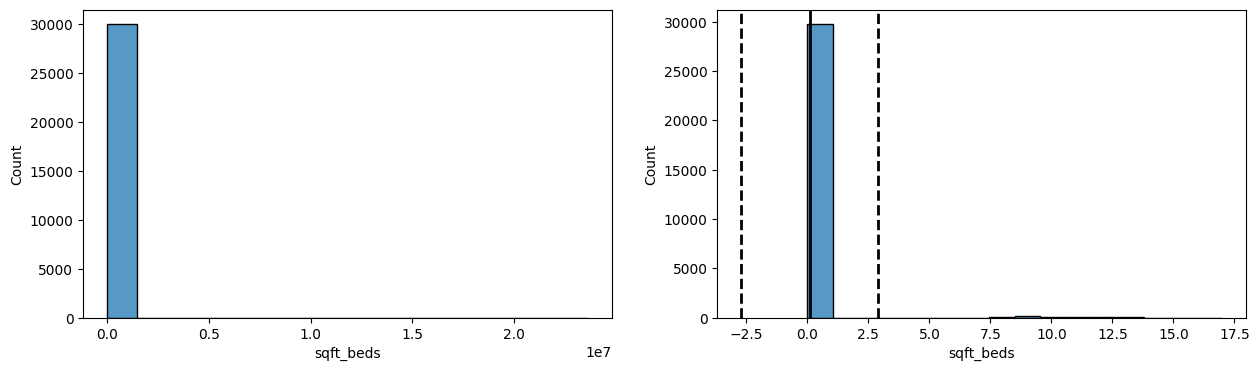

In [90]:

fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #фигура + координатная плоскость
#Строим гистограмму
sns.histplot(data=df_1, x='sqft_beds', ax=axes[0]);

#Логарифмируем
log_sqft_beds = np.log(df_1['sqft_beds'] + 1)
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_sqft_beds, ax=axes[1]);

#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_sqft_beds.mean(), color='k', lw=2)
axes[1].axvline(log_sqft_beds.mean()+ 3 *log_sqft_beds.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_sqft_beds.mean()- 3 *log_sqft_beds.std(),
                color='k', ls='--', lw=2);

### Фильтрация выбросов

In [91]:
#Объявляем функцию, реализующую фильтрацию выбросов по методу z-отклонений
def outliers_z_score(data, feature, log_scale=True):
    if log_scale:
        x = np.log(data[feature]+11)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

#Производим очистку
outliers, temp_cleaned = outliers_z_score(df, 'target')
outliers, temp_cleaned = outliers_z_score(temp_cleaned, 'sqft')
outliers, temp_cleaned = outliers_z_score(temp_cleaned, 'sqft_beds')
print('Shape before cleaning outliers: {}'.format(df.shape))
print('Shape after cleaning outliers: {}'.format(temp_cleaned.shape))

Shape before cleaning outliers: (343204, 507)
Shape after cleaning outliers: (316022, 507)


In [92]:
df_cleaned = temp_cleaned.copy() # Очищенный датасет от выбросов


### Выгрузка готовых данных

In [93]:
df_cleaned.to_csv ('Data/ready_data.csv', index= False)

# Всё одной функцией

In [94]:
def data_cleaner(DATA):
   DATA = DATA.drop_duplicates()
   DATA.dropna(subset=['target'], inplace=True)
   DATA = DATA.reset_index(drop=True)
   DATA["target"] = DATA["target"].apply(clean_target)
   DATA.drop(columns_to_delete, axis=1, inplace=True)
   #------------------------------------------------------------------------------
  # Признак "status"
   DATA['status'] = DATA['status'].fillna('other')
   DATA['status'] = DATA['status'].apply(remake_status)
   DATA['status'] = DATA['status'].apply(lambda x: x if x in top_status else 'other')
   #------------------------------------------------------------------------------
   # Признак "propertyType"
   DATA['propertyType'] = DATA['propertyType'].fillna('no data') 
 # Убираем пустые значения и неизвестные типы
   DATA['propertyType'] = DATA['propertyType'].apply(lambda x: 'no data' if x =="" or x == "unknown" or x ==" " else x)
# Приводим к нижнему регистру
   DATA['propertyType'] = DATA['propertyType'].apply(lambda x: x.lower()) 
   DATA['propertyType'] = DATA['propertyType'].apply(lambda x: x.replace('lot/land', 'land'))
   DATA['propertyType'] = DATA['propertyType'].apply(lambda x: 'land' if (-1 != x.find('land')) else x)
   trash = DATA[DATA['propertyType']=='land'].index
   DATA.drop(trash,  inplace=True)
   DATA = DATA.reset_index(drop=True)
   old = ['one', 'two', '2-', 'stories', '1 1/2', 'tri-', 'single family',
       'singlefamilyresidence', 'townhome',   'bi', 'bi-', 'multi family',
       'hi-', 'high ', 'condominium',  '4 plex', 'other', 'ca2 n', 'cape cod',
       'mid century', 'mid-century',  'mo2 le', 'mo2le', ' / ','mfd',
       'co-op', 'coop',  'modernist', 'key west', 'farm house',
       'queen anne', ' -level', 'floors', 'mobile home', 'manuf/mobile',
       'less than 4 story', 'historic/older', 'quad']

   new = ['1', '2', '2 ', 'story',  '1.5', '3 ', 'single-family',
       'single-family', 'townhouse',  '2 ', '2 ',  'multi-family',
       'high-', 'high-', 'condo',  '4-plex', 'other style', 'cabin', 'cape',
       'midcentury', 'midcentury', 'mobile', 'mobile', '/', 'manufactured',
        'cooperative', 'cooperative',  'modern', 'elevated', 'farmhouse',
        'victorian', ' level',  'story', 'manufactured', 'manufactured',
        '3 story', 'historical', '4']

   for i in range(0,len(new)):
     DATA['propertyType'] = DATA['propertyType'].apply(lambda x: x.replace(old[i], new[i]))
      
   DATA['Property_story'] = DATA['propertyType'].apply(lambda x: x if -1!= x.find('story') else 'no')
   ind_story = DATA[DATA['Property_story']!='no'].index
   DATA.loc[ind_story, 'propertyType'] = DATA['Property_story'][ind_story].apply(type_del_story)
   DATA.drop('Property_story', axis=1, inplace=True)
   new = ['mediterranean', 'english', 'georgian', 'florida','spanish',
        'lake house', 'tudor', 'victorian', 'ranch', 'townhouse',
        'single-family','multi-family', 'single detached', 'detached',
        'high-rise', 'colonial', 'traditional',
        'condo', 'contemporary', 'other style', 'bungalow', 'craftsman',
        'cape cod','cooperative', 'a-frame',  'custom', 'loft',
        'multi-level', 'attached', 'manufactured',  'side-by-side',
        'cottage',  'french', 'cluster home', 'garden home',
        'farmhouse', 'elevated',  'historical', 'transitional','penthouse',
        'modern']

   for i in range(0, len(new)):
     DATA['propertyType'] = DATA['propertyType'].apply(lambda x: new[i] if (-1 != x.find(new[i])) else x)
   old = ['cape','log']
   new = ['cape cod','log home']

   for i in range(0,len(new)):
    DATA['propertyType'] = DATA['propertyType'].apply(lambda x: new[i] if -1!=x.find(old[i])  else x)
   DATA['propertyType'] = DATA['propertyType'].apply(lambda x: 'historical' if (x=='historic') or (x=='historic vintage') else x)
   DATA['propertyType'] = DATA['propertyType'].apply(lambda x: 'other style' if (x=='no data') or (x=='other')  else x)
   DATA['propertyType'] = DATA['propertyType'].apply(lambda x: x if x in top_type else 'other style')
   #------------------------------------------------------------------------------
   # Признак "homeFacts"
   DATA['homeFacts'] = DATA['homeFacts'].apply(lambda x: x.replace('None', '0'))
   old = ["Attch'd", "Addtn'l", '"closet"', "Hennen\'s", "Penske's", "Req'd"]
   new = ['Attch`d', 'Addtn`l', '`closet`', 'Hennen`s', 'Penske`s', 'Req`d']

   for i in range(0, len(old)):
       DATA['homeFacts'] = DATA['homeFacts'].apply(lambda x: x.replace(old[i], new[i]))

   DATA['homeFacts'] = DATA['homeFacts'].apply(lambda x: x.replace("'",'"')) # Меняем одиночные кавычки на двойные
   DATA['Year_built'] = DATA['homeFacts'].apply(lambda x: app(x, 0))
   DATA['Remodeled_year'] = DATA['homeFacts'].apply(lambda x: app(x, 1))
   DATA['Heating'] = DATA['homeFacts'].apply(lambda x: app(x, 2))
   DATA['Cooling'] = DATA['homeFacts'].apply(lambda x: app(x, 3))
   DATA['Parking'] = DATA['homeFacts'].apply(lambda x: app(x, 4))
   DATA['lotsize'] = DATA['homeFacts'].apply(lambda x: app(x, 5))
   DATA['Price/sqft'] = DATA['homeFacts'].apply(lambda x: app(x, 6))
   #------------------------------------------------------------------------------
   year = float(datetime.now().year)
   DATA['Year_built'] = DATA['Year_built'].apply(lambda x: '0' if x == 0 or x == 'No Data' or x == '' or len(x) > 4 else x)
   DATA['Year_built'] = DATA['Year_built'].astype(int)
   ind_built_min= DATA[(DATA['Year_built'] > 0) & (DATA['Year_built'] < 1700)].index
   ind_built_max = DATA[DATA['Year_built'] >= year].index
   DATA.loc[ind_built_min, 'Year_built'] = 0
   DATA.loc[ind_built_max, 'Year_built'] = year
   DATA['Year_built'] =  DATA['Year_built'].apply(lambda x: float(year-x) if x!=0 else -1.0)
   #------------------------------------------------------------------------------
   # Признак "год реконструкции"
   DATA['Remodeled_year'] = DATA['Remodeled_year'].apply(lambda x: '0' if x == 0 or x == '' else x)
   DATA['Remodeled_year'] = DATA['Remodeled_year'].astype(int)

   ind_remodeled_min = DATA[(DATA['Remodeled_year'] > 0) & (DATA['Remodeled_year'] < 1700)].index
   ind_remodeled_max = DATA[DATA['Remodeled_year'] >= year].index
   DATA.loc[ind_remodeled_min, 'Remodeled_year'] = 0
   DATA.loc[ind_remodeled_max, 'Remodeled_year'] = year 
   DATA['Remodeled_year'] =  DATA['Remodeled_year'].apply(lambda x: float(year-x) if x!=0 else -1.0)
   #------------------------------------------------------------------------------
   DATA['Parking'] = DATA['Parking'].apply(lambda x: 0 if x == 0 or x == '' or x == 'No Data' or x == 'No' else 1)
   #------------------------------------------------------------------------------
   DATA['Heating'] = DATA['Heating'].apply(parsing)
   ind_H = DATA[DATA['Heating']=='Central Air'].index
   DATA.loc[ind_H,'Cooling'] = DATA['Heating'][ind_H]
   ind_C = DATA[DATA['Cooling']=='Central Heating'].index
   DATA.loc[ind_C, 'Heating'] = DATA['Heating'][ind_C].apply(change)
   DATA.loc[ind_C,'Cooling']= 'Central'
   ind_CE =DATA[DATA['Cooling']=='Electric Heating'].index
   DATA.loc[ind_CE, 'Cooling'] = DATA['Heating'][ind_CE]
   DATA.loc[ind_CE, 'Heating'] = 'Electric Heating'
   DATA['Heating'] = DATA['Heating'].apply(dop_Heat)
   DATA['Heating'] = DATA['Heating'].apply(in_gce)
   DATA['Heating'] = DATA['Heating'].apply(lambda x: x if x in ind_Heat else 'other')
   DATA['Heating'] = DATA['Heating'].apply(lambda x: 'Central Heating' if x == 'Central Heating' or x == 'Central' or x == 'Heating' else x)
   DATA['Heating'] = DATA['Heating'].apply(lambda x: 'other' if x == 'Other' or x == 'other' else x)
   DATA['Cooling'] = DATA['Cooling'].apply(parsing)
   DATA['Cooling'] = DATA['Cooling'].apply(dop_Cool)
   DATA['Cooling'] = DATA['Cooling'].apply(lambda x: x if x in ind_Cool else 'Other')
   #------------------------------------------------------------------------------
   # Признак "schools"
   DATA['schools'] = DATA['schools'].apply(lambda x: x.replace('None', '0')) # Меняем пропуски на 0.

   old = ["O\'", " O`,",  "'s", "\'Duke\'", "B\'Nai", "B\'inai",  "L\'Ouver", "L\'ouver",  "L\'Banos", "L\'Dovid",
              "Lil\'", "D\'",  "d\'Evelyn", "Q\'", "Loggers\'", "Teach N\'",  "K\'Tana", "R&D`",  "Citizens\'",  "Kids\'",
              "Girls\' ", "d\'Chassidei", "d\'Gur", "d\'Rav", "Pe\'Er", "Be\'Er", "Kids \'R\' Kids", "\'joe\' ",
              "Meadow\'S", "Sheriff\'S", "Friends\' ", "\'Mother\'", "Int\'L", "\'buddy\'"]

   new = ['O`',  " O\', ", '`s', '`Duke`', 'B`Nai', 'B`inai',  'L`Ouver', 'L`Ouver', 'L`Banos', 'L`Dovid',
              'Lil`', 'D`', 'd`Evelyn', 'Q`', 'Loggers`', 'Teach N`', 'K`Tana', "R&D\'",   'Citizens`', 'Kids`',
              'Girls` ',  'd`Chassidei','d`Gur', 'd`Rav', 'Pe`Er', 'Be`Er', 'Kids `R` Kids', '`joe` ',
              'Meadow`S', 'Sheriff`S', 'Friends` ', '`Mother`', 'Int`L', '`buddy`']

   for i in range(0, len(old)):
     DATA['schools'] = DATA['schools'].apply(lambda x: x.replace(old[i], new[i]))
   DATA['schools'] = DATA['schools'].apply(lambda x: x.replace("'",'"'))
   DATA['schools_rating'] = DATA['schools'].apply(lambda x: app_schools(x,0))
   DATA['schools_Distance'] = DATA['schools'].apply(lambda x: app_schools(x,1))
   DATA['schools_Grades'] = DATA['schools'].apply(lambda x: app_schools(x,2))
   #------------------------------------------------------------------------------
   DATA['school_count'] = DATA['schools_rating'].apply(lambda x: len(x))
   #------------------------------------------------------------------------------
   DATA['schools_rating'] = DATA['schools_rating'].apply(rait_ch)
   #------------------------------------------------------------------------------
   DATA['schools_Distance'] = DATA['schools_Distance'].apply(dist_ch)
   #------------------------------------------------------------------------------
   DATA['private pool'] = DATA['private pool'].apply(lambda x: 1 if x=='Yes' else 0)
   DATA['PrivatePool'] = DATA['PrivatePool'].apply(lambda x: 1 if (x=='Yes' or x=='yes') else 0)
   #------------------------------------------------------------------------------
   DATA['PrivatePool'] = DATA['private pool'] | DATA['PrivatePool']
   DATA.drop(['private pool'], axis=1, inplace=True)
   #------------------------------------------------------------------------------
   # Признак "state"
   DATA['state'] = DATA['state'].apply(lambda x: x.upper())
   #------------------------------------------------------------------------------
   # Признак "city
   DATA['city'] = DATA['city'].fillna('other')
   DATA['city'] = DATA['city'].apply(lambda x: x if x in top_city else 'other')
   #------------------------------------------------------------------------------
   # Признак "sqft"
   DATA.sqft = DATA.sqft.fillna('-1.0')
   DATA.sqft = DATA.sqft.apply(make_features_sqft)
   DATA['sqft'] = DATA['sqft'].apply(lambda x: '0' if x=='' else x)
   DATA['sqft'] = DATA['sqft'].astype(float)
   #------------------------------------------------------------------------------
   # Признак "sqft"
   DATA.baths = DATA.baths.fillna('0')
   DATA.baths = DATA.baths.apply(make_baths)
   DATA['beds']= DATA['beds'].fillna('0')
   DATA['beds_Baths'] = DATA['beds'].apply(lambda x: x if -1!=x.find('Bath') else ' ')
   ind_Baths =  DATA[DATA['beds_Baths']!=' '].index
   DATA.drop('beds_Baths', axis=1, inplace=True)
   DATA.loc[ind_Baths, 'baths'] = DATA['baths'][ind_Baths].apply(lambda x: '1 Bath' if x== '0 Baths' else x)
   DATA['baths'] = DATA['baths'].apply(lambda x: x if x in top_baths else 'other')
   DATA['beds'] = DATA['beds'].apply(make_beds)
   DATA.beds = DATA.beds.apply(lambda x: '0 Beds' if len(x)>25 else x)
   DATA['beds'] = DATA['beds'].apply(acre_to_sqft)
   DATA['sqft_beds'] = DATA['beds'].apply(lambda x: x if -1!=x.find('sqft') else '0')
   DATA['sqft_beds'] = DATA['beds'].apply(lambda x: float(re.sub('[^0-9\.]', '', x).strip()) if -1!=x.find('sqft') else 0)
   DATA['count_beds'] = DATA['beds'].apply(lambda x: x if (-1==x.find('sqft'))  else '0')
   DATA['beds'] = DATA['beds'].apply(lambda x: '999 Beds' if -1!=x.find('Bath') else x)
   DATA['count_beds'] = DATA['beds'].apply(lambda x: float(re.sub('[^0-9\.]', '', x).strip()) if -1!=x.find('Beds') else 0)
   DATA.drop(feature_drop, axis=1, inplace=True)
   DATA = pd.get_dummies(DATA)
   outliers, temp_cleaned = outliers_z_score(DATA, 'target')
   outliers, temp_cleaned = outliers_z_score(temp_cleaned, 'sqft')
  
   DATA = temp_cleaned
   return DATA

In [97]:
data = pd.read_csv("Data/data.csv")
df_cleaned_test = data_cleaner(data)
df_cleaned_test.to_csv ('Data/ready_data_test.csv', index= False)

C:\Users\Ghost\AppData\Local\Temp\ipykernel_14868\3005735466.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATA.dropna(subset=['target'], inplace=True)
